In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd

### Leggo i dati

In [2]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]
data

array([['MESH:D005923', 'DB00564'],
       ['MESH:D009503', 'DB01072'],
       ['MESH:D016115', 'DB01759'],
       ...,
       ['MESH:D010518', 'DB04216'],
       ['MESH:D002653', 'DB02701'],
       ['MESH:D013119', 'DB04465']], dtype=object)

### Costruisco $B_{train}$ e $B_{test}$
Le matrici hanno $1$ in presenza di link e $-1$ in assenza. $B_{train}$ possiede inoltre degli elementi nulli che rappresentano i link incogniti

In [3]:
proporzione_train_test = 0.99

diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1])

B_train = np.ones((len(diseases), len(chemicals))) * -1.
B_test  = np.ones((len(diseases), len(chemicals))) * -1.

print("Costruisco B_train e B_test")

for i,t in enumerate(data):
    if i % 10000 == 0:
        print( "%.2f %%" % (100 * (1. * i) / len(data)) )
    dis  = t[0]
    chem = t[1]

    idx_dis  = np.argmax(diseases == dis)
    idx_chem = np.argmax(chemicals == chem)
    B_test[idx_dis, idx_chem] = 1.
    B_train[idx_dis, idx_chem] = 1.

print("censuro alcune entries in B_train")

censor_mask = np.random.choice(2, size = B_train.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
B_train *= censor_mask

Costruisco B_train e B_test
0.00 %
2.14 %
4.29 %
6.43 %
8.57 %
10.71 %
12.86 %
15.00 %
17.14 %
19.29 %
21.43 %
23.57 %
25.71 %
27.86 %
30.00 %
32.14 %
34.29 %
36.43 %
38.57 %
40.72 %
42.86 %
45.00 %
47.14 %
49.29 %
51.43 %
53.57 %
55.72 %
57.86 %
60.00 %
62.14 %
64.29 %
66.43 %
68.57 %
70.72 %
72.86 %
75.00 %
77.14 %
79.29 %
81.43 %
83.57 %
85.72 %
87.86 %
90.00 %
92.14 %
94.29 %
96.43 %
98.57 %
censuro alcune entries in B_train


# Regression of probability

In [4]:
def predict(V,W, temp):
    VWT = jax.vmap(lambda v: jax.vmap(lambda w:  v @ w  )(W))(V)
    return jnp.tanh( temp * VWT )

def loss(V,W,B, temp = 1.):
    #                 annulla il test set                                media sugli elementi non nulli
    #                ,-------'------,                               ,-------'-------,
    return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 )  / jnp.abs(B).sum() 

def loss2(V,W,B, temp = 1.):
     return  1. - jnp.sum( jnp.abs(B)        * (predict(V,W, temp) * B ) )  / jnp.abs(B).sum()    
    
def loss3(V,W,B, temp = 1.):
    BALANCE = (B == 1.) * ( (B == -1).sum() / (jnp.abs(B).sum())) + (B == -1.) * ( (B == +1).sum() / (jnp.abs(B).sum())) 
    return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 * BALANCE )  / jnp.abs(BALANCE).sum() 

    
loss = jax.jit(loss3)
grad = jax.jit(jax.grad(loss, argnums = (0,1)))
m = 3
V = np.random.randn(len(diseases), m)
W = np.random.randn(len(chemicals),m)
print(loss(V,W,B_train))

1.5232258


In [11]:
m = 50
np.random.seed(123)
V = np.random.randn(len(diseases), m)
W = np.random.randn(len(chemicals),m)
alfa = 10.
T = 1e-1
for i in range(500):     # 500
    T = (1. + 1e-3) * T   # 1e-3
    G = grad(V,W,B_train, temp = T)
    newV = V - alfa * G[0]
    newW = W - alfa * G[1]
    if(loss(newV,newW,B_train) < loss(V,W,B_train)):
        alfa *= 1.1
        V = newV
        W = newW
    else:
        alfa *= 0.5
    if i % 20 == 0:
        print(loss(V,W,B_train), loss(V,W,B_test * (B_train == 0) ), T )

1.8871814 1.8941693 0.1001
1.8848083 1.8934736 0.10212113360054008
1.8679764 1.8878791 0.10418307620239121
1.4893554 1.5628546 0.10628665178601042
0.29435557 0.34908834 0.1084327009689636
0.1777218 0.30409437 0.11062208134184763
0.14059255 0.2920542 0.11285566781099542
0.10506325 0.29248902 0.11513435294810027
0.085416146 0.29512906 0.11745904734689995
0.079189554 0.29905134 0.11983067998706232
0.071174435 0.30643147 0.12225019860541815
0.071174435 0.30643147 0.12471857007469002
0.071174435 0.30643147 0.12723678078986755
0.071174435 0.30643147 0.12980583706238458
0.071174435 0.30643147 0.1324267655222549
0.071174435 0.30643147 0.13510061352832758
0.071174435 0.30643147 0.137828449586826
0.071174435 0.30643147 0.14061136377833727
0.071174435 0.30643147 0.14345046819342383
0.071174435 0.30643147 0.1463468973770296


KeyboardInterrupt: 

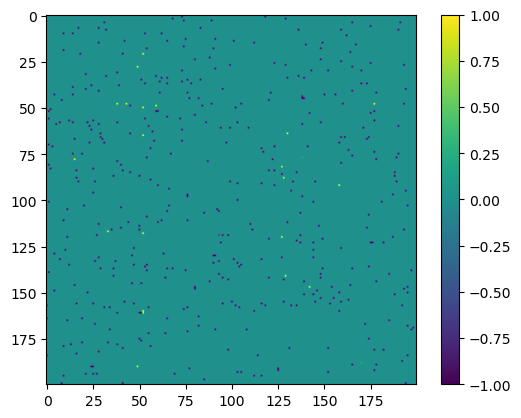

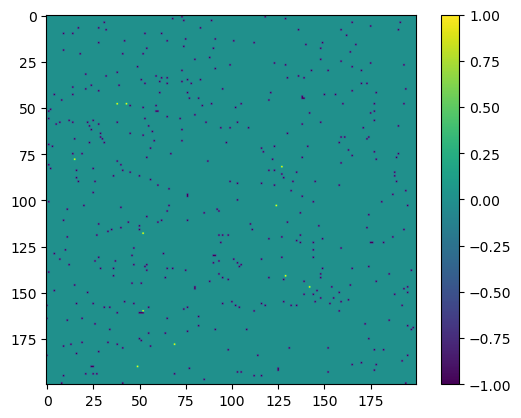

In [12]:
B_hat = predict(V,W,1.)
plt.imshow((B_hat * (B_train == 0.))[150:350,150:350] )
plt.colorbar()
plt.figure()
plt.imshow((B_test * (B_train == 0.))[150:350,150:350] )
plt.colorbar()

## Confusion Matrix

## Test set

<AxesSubplot:>

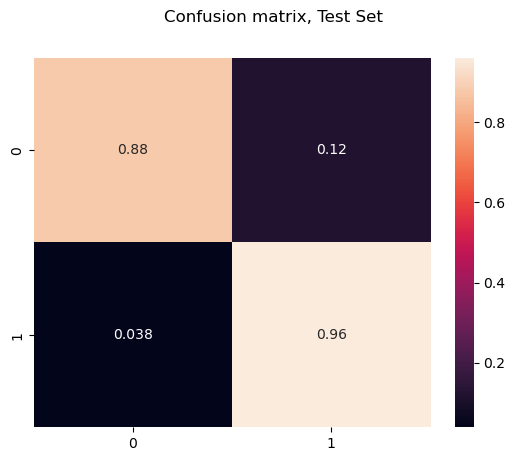

In [13]:
th = - 0.
TP = (((B_test * B_hat) >= th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum() 
FN = (((B_test * B_hat) <  th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum()
TN = (((B_test * B_hat) >= th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum() 
FP = (((B_test * B_hat) <  th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum()
import seaborn as sns
C = np.array( [  
                    [TP, FN], 
                    [FP, TN]
] )
plt.suptitle("Confusion matrix, Test Set")
sns.heatmap(C,annot = True)

## Training set

<AxesSubplot:>

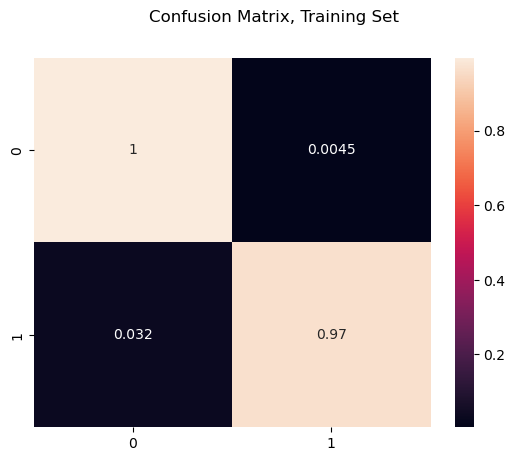

In [14]:
th = 0.
TP = (((B_train * B_hat) >= th) * (B_train ==   1))[B_train != 0.].sum() / (B_train == 1.)[B_train != 0.].sum() 
FN = (((B_train * B_hat) < th) * (B_train ==   1))[B_train != 0.].sum() / (B_train == 1.)[B_train != 0.].sum()
TN = (((B_train * B_hat) >= th) * (B_train ==  -1))[B_train != 0.].sum() / (B_train ==-1.)[B_train != 0.].sum() 
FP = (((B_train * B_hat) < th) * (B_train ==  -1))[B_train != 0.].sum() / (B_train ==-1.)[B_train != 0.].sum()
import seaborn as sns
C = np.array( [  
                    [TP, FN], 
                    [FP, TN]
] )
plt.suptitle("Confusion Matrix, Training Set")
sns.heatmap(C,annot = True)

In [98]:
(B_hat * B_test)[B_train == 0].sum() / (B_train == 0).sum()

DeviceArray(0.95973575, dtype=float32)

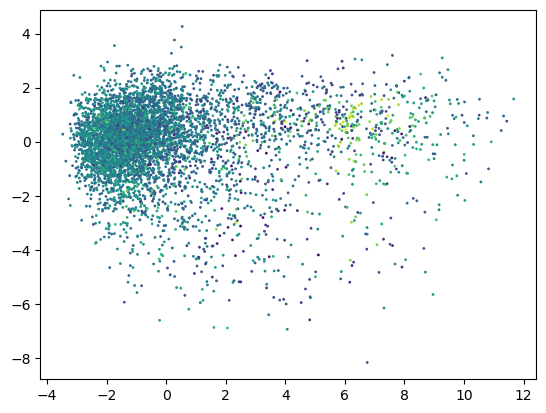

In [15]:
V_zc = V - V.mean(axis = 0)
U,s,Vt = np.linalg.svd(V_zc, full_matrices = False)
V_proj = V_zc @ Vt.T
plt.scatter(V_proj[:,0],V_proj[:,1], s = 1., c=  V_proj[:,2] )

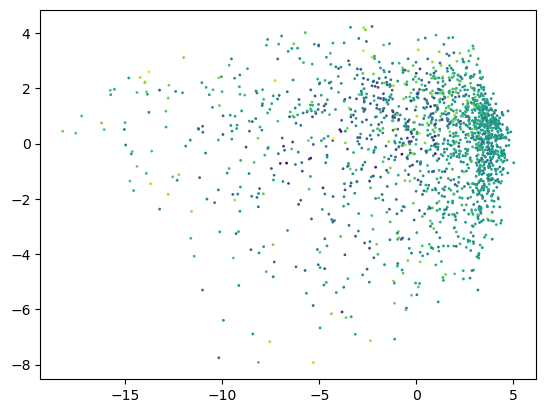

In [16]:
W_zc = W - W.mean(axis = 0)
U,s,Vt = np.linalg.svd(W_zc, full_matrices = False)
W_proj = W_zc @ Vt.T
plt.scatter(W_proj[:,0],W_proj[:,1], s = 1., c = W_proj[:,2])

# Topological similarity approach

Approccio "delle slide"

### Data retrieve

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd

In [18]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]
data

array([['MESH:D005923', 'DB00564'],
       ['MESH:D009503', 'DB01072'],
       ['MESH:D016115', 'DB01759'],
       ...,
       ['MESH:D010518', 'DB04216'],
       ['MESH:D002653', 'DB02701'],
       ['MESH:D013119', 'DB04465']], dtype=object)

In [19]:
diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1])

B = np.zeros((len(diseases), len(chemicals)))

for i,t in enumerate(data):
    if i % 10000 == 0:
        print( "%.2f %%" % (100 * (1. * i) / len(data)) )
    dis  = t[0]
    chem = t[1]

    idx_dis  = np.argmax(diseases == dis)
    idx_chem = np.argmax(chemicals == chem)
    B[idx_dis, idx_chem] = 1.

0.00 %
2.14 %
4.29 %
6.43 %
8.57 %
10.71 %
12.86 %
15.00 %
17.14 %
19.29 %
21.43 %
23.57 %
25.71 %
27.86 %
30.00 %
32.14 %
34.29 %
36.43 %
38.57 %
40.72 %
42.86 %
45.00 %
47.14 %
49.29 %
51.43 %
53.57 %
55.72 %
57.86 %
60.00 %
62.14 %
64.29 %
66.43 %
68.57 %
70.72 %
72.86 %
75.00 %
77.14 %
79.29 %
81.43 %
83.57 %
85.72 %
87.86 %
90.00 %
92.14 %
94.29 %
96.43 %
98.57 %


In [20]:
proporzione_train_test = 0.9
validation_set = np.random.choice(2, size = B_train.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
validation_set

array([[1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 1, 1]])

### Definisco la matrice delle similaritá

In [21]:
S = jax.jit(
    jax.vmap(
    lambda a:
    jax.vmap(
        lambda b:
            ((a > 0.5) *1.) @ (( b > 0.5) * 1.)
    )(B)
))(B)
S = B@B.T

In [22]:
B_hat = jax.vmap(
                lambda s:
                    jax.vmap(
                        lambda b: 
                            (s.sum() > 0.) * ((s @ b) / (s.sum()))
                    )
                    (B.T)
            )(S)

jnp.linalg.norm( (B_hat  - B)*validation_set )

DeviceArray(736.2, dtype=float32)

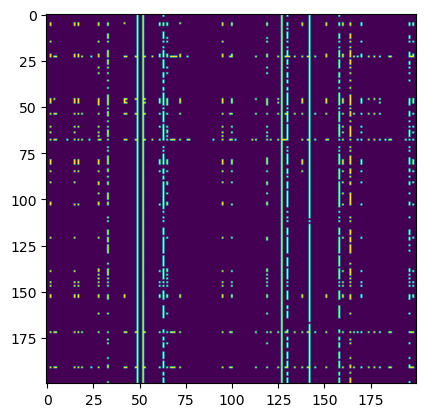

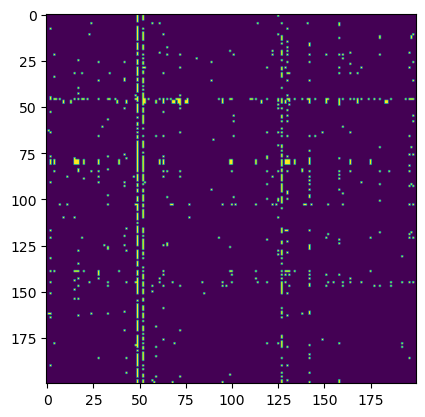

In [24]:
plt.imshow(B_hat[150:350,150:350] > 0.5)
plt.figure()
plt.imshow(B[150:350,150:350] > 0.5)

<AxesSubplot:>

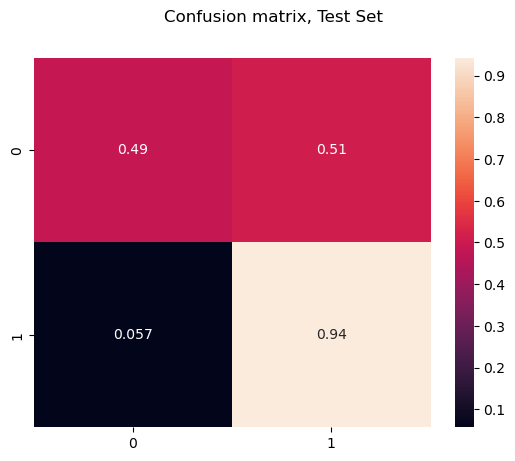

In [154]:
TP = (((B_hat > 0.5) * (B > 0.5)) * validation_set).sum() / (((B > 0.5)) * validation_set).sum()
FN = (((B_hat < 0.5) * (B > 0.5)) * validation_set).sum() / (((B > 0.5)) * validation_set).sum()
TN = (((B_hat < 0.5) * (B < 0.5)) * validation_set).sum() / (((B < 0.5)) * validation_set).sum()
FP = (((B_hat > 0.5) * (B < 0.5)) * validation_set).sum() / (((B < 0.5)) * validation_set).sum()

import seaborn as sns
C = np.array( [  
                    [TP, FN], 
                    [FP, TN]
] )
plt.suptitle("Confusion matrix, Test Set")
sns.heatmap(C,annot = True)

# Similarity induced by community analysis

In [131]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd
from networkx.algorithms import bipartite

In [132]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]
data

array([['MESH:D005923', 'DB00564'],
       ['MESH:D009503', 'DB01072'],
       ['MESH:D016115', 'DB01759'],
       ...,
       ['MESH:D010518', 'DB04216'],
       ['MESH:D002653', 'DB02701'],
       ['MESH:D013119', 'DB04465']], dtype=object)

In [133]:
G = nx.Graph()
for link in data:
    G.add_edge(link[0],link[1])

### Costruisco le matrici di proiezione

In [138]:
diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1]) 
G_dis = bipartite.projected_graph(G, diseases)
G_chem = bipartite.projected_graph(G, chemicals)

In [140]:
nx.adjacency_matrix(G_dis)

<5535x5535 sparse array of type '<class 'numpy.intc'>'
	with 21270702 stored elements in Compressed Sparse Row format>

In [157]:
communities = nx.community.louvain_communities(G_chem, seed=123)
communities

[{'DB00004',
  'DB00015',
  'DB00020',
  'DB00040',
  'DB00041',
  'DB00059',
  'DB00069',
  'DB00091',
  'DB00093',
  'DB00098',
  'DB00104',
  'DB00115',
  'DB00118',
  'DB00122',
  'DB00126',
  'DB00134',
  'DB00136',
  'DB00140',
  'DB00141',
  'DB00143',
  'DB00145',
  'DB00147',
  'DB00151',
  'DB00158',
  'DB00162',
  'DB00166',
  'DB00168',
  'DB00169',
  'DB00170',
  'DB00171',
  'DB00173',
  'DB00175',
  'DB00176',
  'DB00177',
  'DB00178',
  'DB00179',
  'DB00181',
  'DB00182',
  'DB00184',
  'DB00185',
  'DB00188',
  'DB00189',
  'DB00192',
  'DB00193',
  'DB00197',
  'DB00199',
  'DB00200',
  'DB00201',
  'DB00203',
  'DB00206',
  'DB00207',
  'DB00215',
  'DB00218',
  'DB00219',
  'DB00220',
  'DB00224',
  'DB00225',
  'DB00226',
  'DB00227',
  'DB00228',
  'DB00230',
  'DB00232',
  'DB00236',
  'DB00238',
  'DB00244',
  'DB00250',
  'DB00252',
  'DB00254',
  'DB00255',
  'DB00256',
  'DB00262',
  'DB00264',
  'DB00266',
  'DB00267',
  'DB00273',
  'DB00275',
  'DB00277',

In [158]:
len(communities)

3

# Costruisco la similaritá tra chemicals basata sull'appartenenza alla stessa comunitá

In [170]:
S_diseases = jax.jit(
    jax.vmap(
    lambda a:
    jax.vmap(
        lambda b:
            ((a > 0.5) *1.) @ (( b > 0.5) * 1.)
    )(B)
))(B)

In [172]:
S_chemicals = np.array([
    [
            1 if (
                    ( a in communities[0] and b in communities[0] ) or 
                    ( a in communities[1] and b in communities[1] ) or 
                    ( a in communities[2] and b in communities[2] ) 
            ) else 0 
        for b in chemicals
    ]
    for a in chemicals
])

In [ ]:
S     = jax.jit(
                jax.vmap(
                    lambda a:
                    jax.vmap(
                        lambda b:
                            jax.vmap(
                                lambda a_el, b_el, s:
                                    a_el * s @ s * b_el
                            )(a,b,S[1::])
                    )(B[:100])
            ))(B[:100])

B_hat = jax.vmap(
                lambda s:
                    jax.vmap(
                        lambda b: 
                            (s.sum() > 0.) * ((s @ b) / (s.sum()))
                    )
                    (B.T)
            )(S)

jnp.linalg.norm( (B_hat  - B)*validation_set )

In [182]:
S_diseases.shape, S_chemicals.shape

((5535, 5535), (1662, 1662))